## Feature Engineering for the unemployment Rate in Kenya

In [1]:
import os
import re
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
import gdown

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
pd.set_option('mode.use_inf_as_na', True)


### Define functions for repeated tasks


In [2]:
# Function to extract headers from a given file
def extract_headers(file_path):
    try:
        # Read the first sheet of the Excel file
        df = pd.read_excel(file_path)

        # Get the column headers
        headers = df.columns.tolist()

        return headers
    except Exception as e:
        return []
##########################################


def replace_characters(dataframe):
    # Iterate through the columns and update their names
    for col in dataframe.columns:
        # replace spaces, whitespaces, parenthesis with underscore and remove commas and % signs
        new_col_name = re.sub(r'[\s(),]+', '_', col).strip('_')
        new_col_name = re.sub(r'%', 'Percent', new_col_name)

        # Update the column name in the DataFrame
        dataframe.rename(columns={col: new_col_name}, inplace=True)

    # Return a list of the modified column names
    return dataframe.columns

##########################################
# replace dataframe datatype to numeric if it is actually numeric
def convert_to_float_or_pass(input_string):
    try:
        result = float(input_string)
        return result
    except ValueError:
        pass

# create barplots for all columns
# Create separate subplots for each column
def barplots(df):
    nrows=int(len(df.columns)/2)
    fig, axes = plt.subplots(nrows=nrows,ncols=len(df.columns)-nrows, figsize=(15, 5))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=col, data=df, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel('Value')

        plt.tight_layout()
    return plt.show()





## Read the data into dataframe(s) and rename the column names for easy readibility

In [3]:
file_path = r"C:\Users\wanji\Downloads\Feature_Engineered_Dataset.csv"
unemployment_historical = pd.read_csv(file_path, skiprows=0)
unemployment_historical.columns = replace_characters(unemployment_historical)

# Continue with your data processing here
unemployment_historical.shape
unemployment_historical.head()



,Year,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Inflation,Dollar_Rate,Total_Unemployment,IncomePerCapita_TotalPop_Growth_Ratio
0,2000,982855,2.92,50.46,46.89,9.98,76.175542,3.13,0.864619
1,2001,1020111,3.03,50.03,46.87,5.73,78.563195,3.07,0.976607
2,2002,1025583,3.03,49.61,46.84,1.97,78.749142,3.09,1.000000
3,2003,1055658,2.97,49.18,46.82,9.81,84.148300,3.04,0.913363
4,2004,1109338,2.99,48.76,46.79,11.80,80.650112,3.00,0.935571


## Check the data types


In [4]:
unemployment_historical['Year']=pd.to_datetime(unemployment_historical['Year'],format='%Y').dt.year
unemployment_historical.dtypes
unemployment_historical

,Year,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Inflation,Dollar_Rate,Total_Unemployment,IncomePerCapita_TotalPop_Growth_Ratio
0,2000,982855,2.92,50.46,46.89,9.98,76.175542,3.13,0.864619
1,2001,1020111,3.03,50.03,46.87,5.73,78.563195,3.07,0.976607
2,2002,1025583,3.03,49.61,46.84,1.97,78.749142,3.09,1.000000
3,2003,1055658,2.97,49.18,46.82,9.81,84.148300,3.04,0.913363
4,2004,1109338,2.99,48.76,46.79,11.80,80.650112,3.00,0.935571
5,2005,1172784,2.98,48.34,46.77,9.91,75.566327,2.97,0.921914
6,2006,1249470,2.97,47.91,46.75,6.03,72.145463,2.94,0.922375
7,2007,1336849,2.97,47.48,46.72,4.27,67.466765,2.92,0.917403
8,2008,1357262,2.98,47.05,46.71,15.11,69.003071,2.98,0.932878
9,2009,5361462,2.96,46.62,46.69,10.54,77.339537,2.92,0.704230


## Convert the Year column into index and convert the series into time series

In [5]:
unemployment_historical.index=pd.to_datetime(unemployment_historical['Year'],format='%Y').dt.year
unemployment_historical


,Year,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Inflation,Dollar_Rate,Total_Unemployment,IncomePerCapita_TotalPop_Growth_Ratio
Year,,,,,,,,,
2000,2000,982855,2.92,50.46,46.89,9.98,76.175542,3.13,0.864619
2001,2001,1020111,3.03,50.03,46.87,5.73,78.563195,3.07,0.976607
2002,2002,1025583,3.03,49.61,46.84,1.97,78.749142,3.09,1.000000
2003,2003,1055658,2.97,49.18,46.82,9.81,84.148300,3.04,0.913363
2004,2004,1109338,2.99,48.76,46.79,11.80,80.650112,3.00,0.935571
2005,2005,1172784,2.98,48.34,46.77,9.91,75.566327,2.97,0.921914
2006,2006,1249470,2.97,47.91,46.75,6.03,72.145463,2.94,0.922375
2007,2007,1336849,2.97,47.48,46.72,4.27,67.466765,2.92,0.917403
2008,2008,1357262,2.98,47.05,46.71,15.11,69.003071,2.98,0.932878


## Replace data types to numeric values

In [6]:
# replace all column types to numeric if they are numeric indeed
for col in unemployment_historical.columns:
    if unemployment_historical[col].dtype == 'object':
        unemployment_historical[col] = unemployment_historical[col].apply(convert_to_float_or_pass)

In [7]:
# Create a dictionary to map old column names to new, simpler names for all columns
column_name_mapping = {
    'Inflation_Rate': 'Inflation',
    'Labour_Force': 'Labor',
    'Nominal_GDP_prices_Ksh_Million': 'Nominal_GDP_Ksh',
    'Annual_GDP_growth_Percent': 'GDP_Growth',
    'Real_GDP_prices_Ksh_Million': 'Real_GDP_Ksh',
    'population_growth': 'Population_Growth',
    'Population_total': 'Total_Population',
    'Urban_population_growth_annual_Percent': 'Urban_Population_Growth',
    'Adjusted_net_national_income_per_capita_annual_Percent_growth': 'Income_Per_Capita_Growth',
    'Adjusted_savings:_education_expenditure_current_US$': 'Education_Expenditure_usd',
    'Labor_force_participation_rate_for_ages_15-24_female_Percent_modeled_ILO_estimate': 'Female_Labor_Participation',
    'Labor_force_participation_rate_for_ages_15-24_male_Percent_modeled_ILO_estimate': 'Male_Labor_Participation',
    'Unemployment_female_Percent_of_female_labor_force_modeled_ILO_estimate': 'Female_Unemployment',
    'Unemployment_male_Percent_of_male_labor_force_modeled_ILO_estimate': 'Male_Unemployment',
    'Unemployment_total_Percent_of_total_labor_force_modeled_ILO_estimate': 'Total_Unemployment'
}

# Rename the columns in the dataframe
unemployment_df= unemployment_historical.rename(columns=column_name_mapping)


## convert the usd expenditure to Ksh since all the other columns represent ksh

In [8]:
print(unemployment_df.columns)

Index(['Year', 'Real_GDP_Ksh', 'Population_Growth',
       'Female_Labor_Participation', 'Male_Labor_Participation', 'Inflation',
       'Dollar_Rate', 'Total_Unemployment',
       'IncomePerCapita_TotalPop_Growth_Ratio'],
      dtype='object')


In [13]:
print(usd_to_Ksh.columns)

Index(['YEAR', 'DOLLAR RATE ANNUALLY'], dtype='object')


In [16]:
unemployment_df.fillna(unemployment_df.median(), inplace=True)
usd_to_Ksh = pd.read_excel(r"C:\Users\wanji\Downloads\DOLLAR RATE.xlsx")
usd_to_Ksh.index = usd_to_Ksh["YEAR"]


In [17]:

# If 'DOLLAR RATE ANNUALLY' is the correct column name in 'usd_to_Ksh':
usd_to_ksh_column = 'DOLLAR RATE ANNUALLY'
exchange_rate = usd_to_Ksh[usd_to_ksh_column]


In [18]:
# Hypothetical example: Creating 'Education_Expenditure_Ksh' column using a provided exchange rate
# The following line creates a placeholder column filled with zeros if the column doesn't exist
unemployment_df['Education_Expenditure'] = unemployment_df.get('Education_Expenditure', 0)

# Calculate 'Education_Expenditure_Ksh' using the provided formula
unemployment_df['Education_Expenditure_Ksh'] = unemployment_df['Education_Expenditure'] * exchange_rate


In [19]:
# Create 'Education_Expenditure_Ksh' by converting the original currency to Ksh using the exchange rate
unemployment_df['Education_Expenditure_Ksh'] = unemployment_df['Education_Expenditure'] * usd_to_Ksh['DOLLAR RATE ANNUALLY']


In [20]:
# Calculate "Education_Expenditure_Ksh" using the provided formula
unemployment_df["Education_Expenditure_Ksh"] = unemployment_df["Education_Expenditure_Ksh"] * usd_to_Ksh["DOLLAR RATE ANNUALLY"]

# Drop the "Education_Expenditure" column if it's no longer needed
unemployment_df.drop(["Education_Expenditure_Ksh"], axis=1, inplace=True)

# If you want to rename the "DOLLAR RATE ANNUALLY" column to "Dollar_Rate," you can do so as follows:
usd_to_Ksh.rename(columns={"DOLLAR RATE ANNUALLY": "Dollar_Rate"}, inplace=True)


In [21]:
unemployment_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,23.0,2.011000e+03,6.782330e+00,2000.000000,2.005500e+03,2.011000e+03,2.016500e+03,2.022000e+03
Real_GDP_Ksh,23.0,5.013512e+06,3.346256e+06,982855.000000,1.211127e+06,6.090206e+06,7.739792e+06,9.851329e+06
Population_Growth,23.0,2.563478e+00,4.305030e-01,1.910000,2.190000e+00,2.660000e+00,2.970000e+00,3.030000e+00
Female_Labor_Participation,23.0,4.576043e+01,2.896549e+00,41.540000,4.336500e+01,4.577000e+01,4.812500e+01,5.046000e+01
Male_Labor_Participation,23.0,4.575261e+01,1.759202e+00,41.960000,4.589000e+01,4.665000e+01,4.676000e+01,4.689000e+01
Inflation,23.0,7.613043e+00,3.251344e+00,1.970000,5.505000e+00,6.580000e+00,9.860000e+00,1.511000e+01
Dollar_Rate,23.0,8.813952e+01,1.411275e+01,67.466765,7.795137e+01,8.452290e+01,1.013982e+02,1.178443e+02
Total_Unemployment,23.0,3.448261e+00,9.915949e-01,2.760000,2.855000e+00,2.980000e+00,3.325000e+00,5.640000e+00
IncomePerCapita_TotalPop_Growth_Ratio,23.0,6.829000e-01,2.702210e-01,0.000000,5.582819e-01,7.042297e-01,9.196588e-01,1.000000e+00
Education_Expenditure,23.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Check the distribution of the data

array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Real_GDP_Ksh'}>,
        <AxesSubplot:title={'center':'Population_Growth'}>],
       [<AxesSubplot:title={'center':'Female_Labor_Participation'}>,
        <AxesSubplot:title={'center':'Male_Labor_Participation'}>,
        <AxesSubplot:title={'center':'Inflation'}>],
       [<AxesSubplot:title={'center':'Dollar_Rate'}>,
        <AxesSubplot:title={'center':'Total_Unemployment'}>,
        <AxesSubplot:title={'center':'IncomePerCapita_TotalPop_Growth_Ratio'}>],
       [<AxesSubplot:title={'center':'Education_Expenditure'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

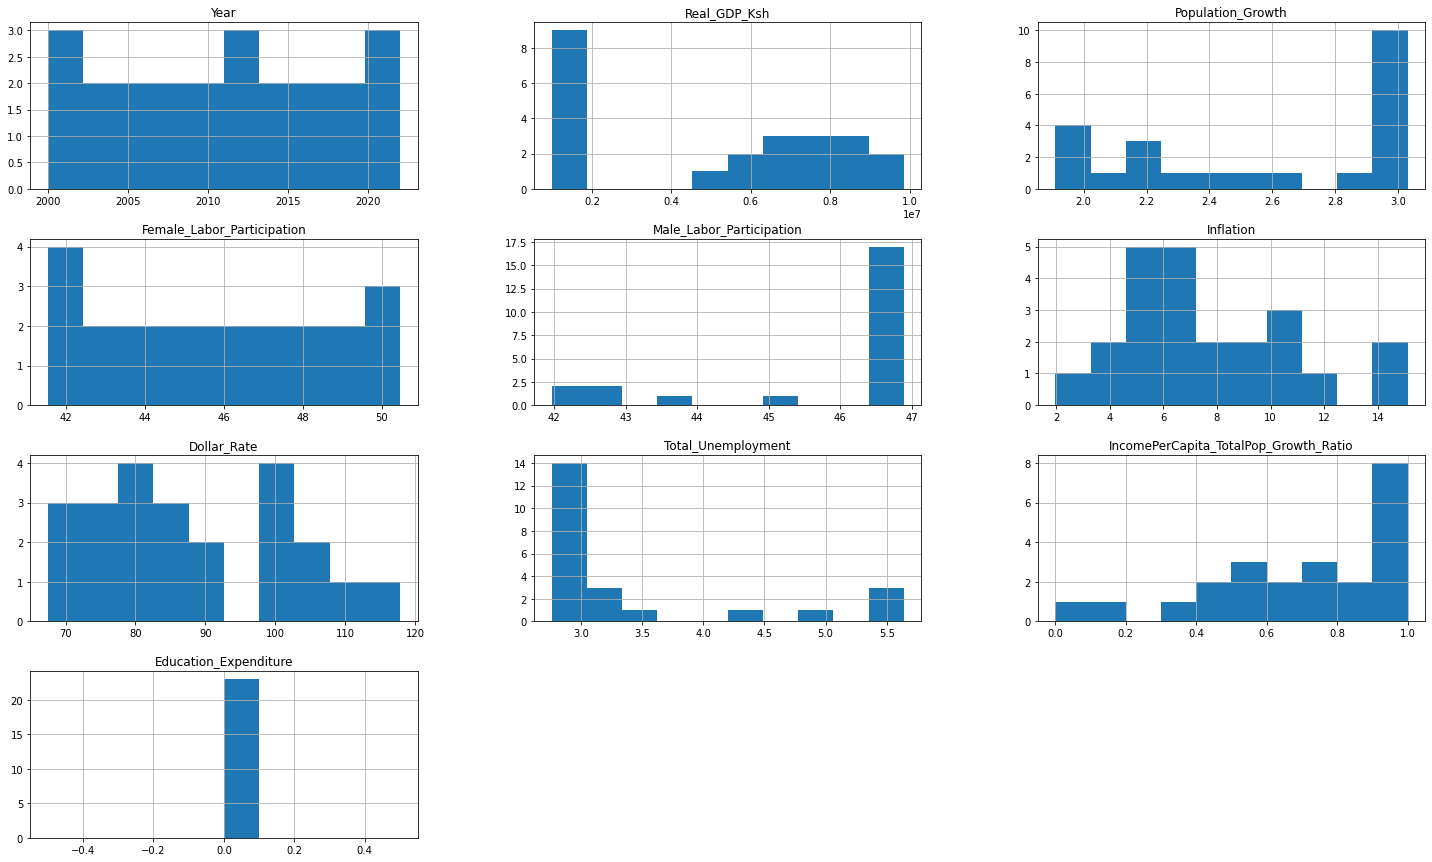

In [25]:
unemployment_df.hist(figsize=(25,15))

posx and posy should be finite values
posx and posy should be finite values


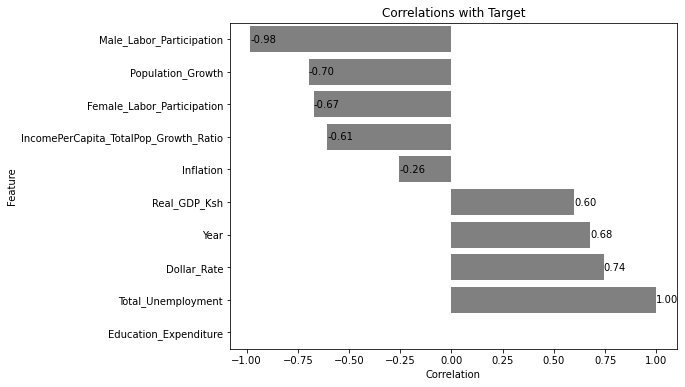

In [26]:
# Calculate the correlations between features and the target
correlations = unemployment_df.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations, y=correlations.index, orient='h',color="grey")
plt.title('Correlations with Target')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')




## Scale the data to calculate the correlations

In [27]:
scaling=MinMaxScaler()
scaled=scaling.fit_transform(unemployment_df)
scaled_df= pd.DataFrame(scaled, columns=unemployment_df.columns)
scaled_df.index=unemployment_df.index

scaled_df.head()

,Year,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Inflation,Dollar_Rate,Total_Unemployment,IncomePerCapita_TotalPop_Growth_Ratio,Education_Expenditure
Year,,,,,,,,,,
2000,0.000000,0.000000,0.901786,1.000000,1.000000,0.609589,0.172870,0.128472,0.864619,0.0
2001,0.045455,0.004201,1.000000,0.951794,0.995943,0.286149,0.220265,0.107639,0.976607,0.0
2002,0.090909,0.004818,1.000000,0.904709,0.989858,0.000000,0.223956,0.114583,1.000000,0.0
2003,0.136364,0.008209,0.946429,0.856502,0.985801,0.596651,0.331130,0.097222,0.913363,0.0
2004,0.181818,0.014262,0.964286,0.809417,0.979716,0.748097,0.261691,0.083333,0.935571,0.0


In [28]:
print(scaled_df.columns)

Index(['Year', 'Real_GDP_Ksh', 'Population_Growth',
       'Female_Labor_Participation', 'Male_Labor_Participation', 'Inflation',
       'Dollar_Rate', 'Total_Unemployment',
       'IncomePerCapita_TotalPop_Growth_Ratio', 'Education_Expenditure'],
      dtype='object')


posx and posy should be finite values
posx and posy should be finite values


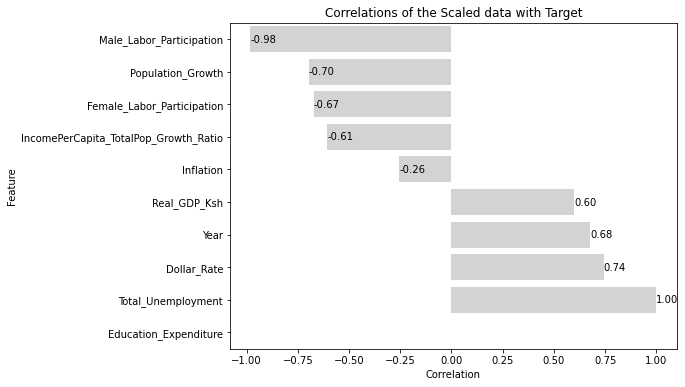

In [29]:

# Calculate the correlations between features and the target
correlations_new = scaled_df.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations_new, y=correlations_new.index, orient='h',color="lightgrey")
plt.title('Correlations of the Scaled data with Target')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_new):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')



###  Comparing (above) the correations of the scaled data to the correlations of the original data, we realize that they are exactly the same. This validates our scaling method!

##  Calculate ratio of each field with another to compare against the unemployment rate with a condition given that the correlation with the unemployment rate is > 0.5

In [30]:
# Get columns without the last
cols_without_last = scaled_df.drop(['Total_Unemployment'],axis=1).columns

# Create unique pairs without the last column
unique_pairs = list(combinations(cols_without_last, 2))

# Calculate ratios and check correlation with the last column
ratios = pd.DataFrame()
for col1, col2 in unique_pairs:
    ratio_name = f'{col1}_{col2}_Ratio'
    ratio = scaled_df[col1] / scaled_df[col2]

    correlation_with_last = ratio.corr(unemployment_df['Total_Unemployment'])

    if (correlation_with_last > 0.5) or (correlation_with_last < -0.5):
        ratios[ratio_name] = ratio



ratios = ratios[sorted(ratios.columns)]
#remove nan values by filling up with median
ratios.fillna(ratios.median(),inplace=True)
ratios.head()

,Dollar_Rate_IncomePerCapita_TotalPop_Growth_Ratio_Ratio,Female_Labor_Participation_IncomePerCapita_TotalPop_Growth_Ratio_Ratio,Female_Labor_Participation_Inflation_Ratio,Male_Labor_Participation_IncomePerCapita_TotalPop_Growth_Ratio_Ratio,Male_Labor_Participation_Inflation_Ratio,Population_Growth_IncomePerCapita_TotalPop_Growth_Ratio_Ratio,Real_GDP_Ksh_Female_Labor_Participation_Ratio,Real_GDP_Ksh_IncomePerCapita_TotalPop_Growth_Ratio_Ratio,Real_GDP_Ksh_Inflation_Ratio,Real_GDP_Ksh_Male_Labor_Participation_Ratio,Real_GDP_Ksh_Population_Growth_Ratio,Year_Female_Labor_Participation_Ratio,Year_IncomePerCapita_TotalPop_Growth_Ratio_Ratio,Year_Inflation_Ratio,Year_Male_Labor_Participation_Ratio,Year_Population_Growth_Ratio
Year,,,,,,,,,,,,,,,,
2000,0.199938,1.156579,1.640449,1.156579,1.640449,1.042986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001,0.225541,0.974592,3.326215,1.019799,3.480504,1.023953,0.004414,0.004302,0.014681,0.004218,0.004201,0.047757,0.046543,0.158849,0.045640,0.045455
2002,0.223956,0.904709,0.840822,0.989858,1.646336,1.000000,0.005325,0.004818,1.387881,0.004867,0.004818,0.100484,0.090909,1.694834,0.091841,0.090909
2003,0.362540,0.937746,1.435515,1.079310,1.652223,1.036202,0.009585,0.008988,0.013759,0.008327,0.008674,0.159210,0.149298,0.228548,0.138328,0.144082
2004,0.279712,0.865158,1.081967,1.047185,1.309610,1.030692,0.017620,0.015244,0.019064,0.014557,0.014790,0.224629,0.194339,0.243041,0.185583,0.188552


In [31]:
print(scaled_df.columns)

Index(['Year', 'Real_GDP_Ksh', 'Population_Growth',
       'Female_Labor_Participation', 'Male_Labor_Participation', 'Inflation',
       'Dollar_Rate', 'Total_Unemployment',
       'IncomePerCapita_TotalPop_Growth_Ratio', 'Education_Expenditure'],
      dtype='object')


In [33]:
# Assuming the column names exist in the DataFrame 'scaled_df'
scaled_df['Urban_Population_Growth_Income_Per_Capita_Growth_Ratio'] = scaled_df['Urban_Population_Growth'] / scaled_df['Income_Per_Capita_Growth']


KeyError: 'Urban_Population_Growth'

In [32]:
ratios["IncomePerCapita_TotalPop_Growth_Ratio"] = scaled_df["Urban_Population_Growth_Income_Per_Capita_Growth_Ratio"]


KeyError: 'Urban_Population_Growth_Income_Per_Capita_Growth_Ratio'

In [ ]:
#ratios.fillna(ratios.median(),inplace=True)
ratios["Total_Unemployment"]=unemployment_df["Total_Unemployment"]
ratios.corr()["Total_Unemployment"]

Dollar_Rate_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio                     0.431668
Female_Labor_Participation_Inflation_Ratio                                                  -0.510485
Female_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio     -0.626034
Labor_Total_Population_Ratio_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio    0.576646
Male_Labor_Participation_Inflation_Ratio                                                    -0.592210
Male_Labor_Participation_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio       -0.469936
Population_Growth_Urban_Population_Growth_Income_Per_Capita_Growth_Ratio_Ratio              -0.593588
Real_GDP_Ksh_Female_Labor_Participation_Ratio                                                0.630824
Real_GDP_Ksh_Inflation_Ratio                                                                 0.611061
Real_GDP_Ksh_Male_Labor_Participation_Ratio                                       

# Correlations for all the ratios

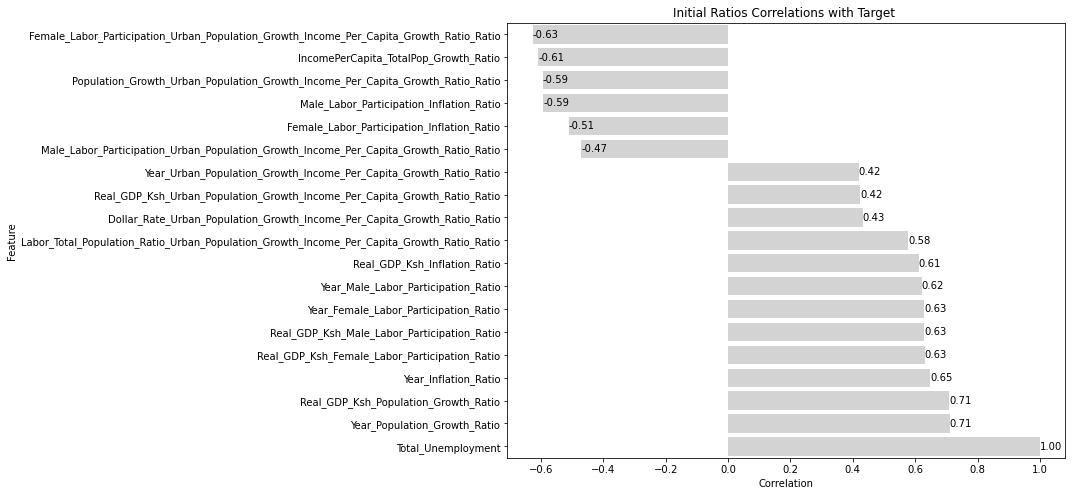

In [ ]:

# Calculate the correlations between features and the target
correlations_ratios = ratios.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations_ratios, y=correlations_ratios.index, orient='h',color="lightgrey")
plt.title('Initial Ratios Correlations with Target ')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_ratios):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')

In [ ]:
ratios_final = ratios[["Total_Unemployment", "IncomePerCapita_TotalPop_Growth_Ratio"]]


### From the above correlation plot, we will remove all the factors which try to divide percentages by the actual numbers, because they would not reveal a meaninful correlation even if mathematically it is a high number. Moreover, if an original feature shows a stronger correlation or anti-correlation as compared to either of these ratios, we kept the original feature instead. Using this intuition, we decide to only consider "Labor_Total_Population_Ratio" and "Urban_Population_Growth_Income_Per_Capita_Growth_Ratio" from above.

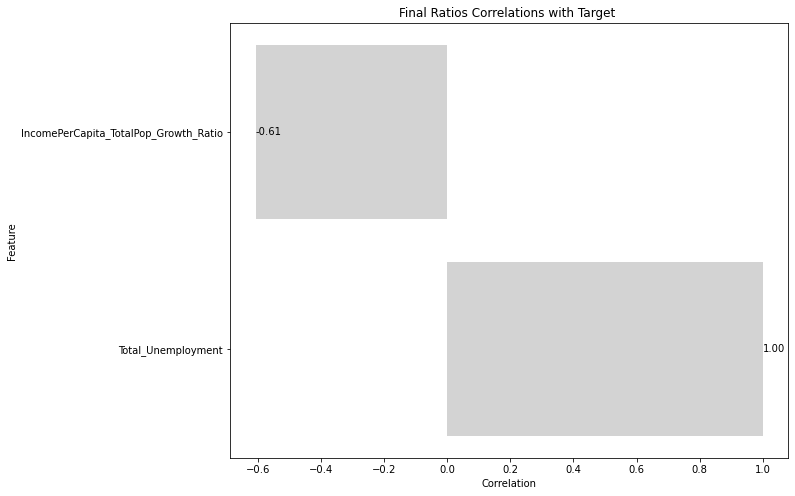

In [ ]:
#ratios.drop("Urban_Population_Growth_Income_Per_Capita_Growth_Ratio",axis=1,inplace=True)
ratios_final.head()
# Calculate the correlations between features and the target
correlations_ratios = ratios_final.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations_ratios, y=correlations_ratios.index, orient='h',color="lightgrey")
plt.title('Final Ratios Correlations with Target ')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_ratios):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')

# Create the final data set based on the following findings:
- Male and female labor force participation are strongly anticorrelated
-  Labor to total population ratio is better than these two factors alone
- Plus all the original features in

In [ ]:
unemployment_final=unemployment_df[['Real_GDP_Ksh','Population_Growth','Female_Labor_Participation','Male_Labor_Participation','Inflation','Dollar_Rate']]
#scaled_final=scaled_df[['Real_GDP_Ksh','Population_Growth','Female_Labor_Participation','Male_Labor_Participation','Education_Expenditure_Ksh','Total_Unemployment']]

## Create the final dataset:
- with the original data and ratios

In [ ]:
#ratios_scaled_final=pd.concat([scaled_final,ratios_final],axis=1)
ratios_original_final=pd.concat([unemployment_final,ratios_final],axis=1)
#ratios_scaled_final.to_csv("Scaled_data_and_Ratios.csv")
ratios_original_final.to_csv("Feature_Engineered_Dataset.csv")

In [ ]:
ratios_original_final


,Real_GDP_Ksh,Population_Growth,Female_Labor_Participation,Male_Labor_Participation,Inflation,Dollar_Rate,Total_Unemployment,IncomePerCapita_TotalPop_Growth_Ratio
Year,,,,,,,,
2000,982855,2.92,50.46,46.89,9.98,76.175542,3.13,0.864619
2001,1020111,3.03,50.03,46.87,5.73,78.563195,3.07,0.976607
2002,1025583,3.03,49.61,46.84,1.97,78.749142,3.09,1.000000
2003,1055658,2.97,49.18,46.82,9.81,84.148300,3.04,0.913363
2004,1109338,2.99,48.76,46.79,11.80,80.650112,3.00,0.935571
2005,1172784,2.98,48.34,46.77,9.91,75.566327,2.97,0.921914
2006,1249470,2.97,47.91,46.75,6.03,72.145463,2.94,0.922375
2007,1336849,2.97,47.48,46.72,4.27,67.466765,2.92,0.917403
2008,1357262,2.98,47.05,46.71,15.11,69.003071,2.98,0.932878


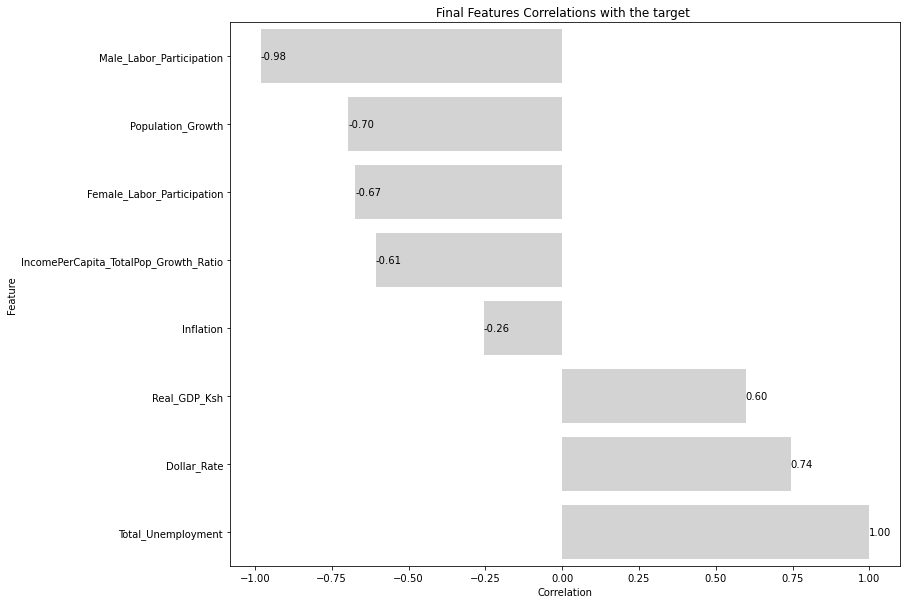

In [ ]:
# Calculate the correlations between features and the target
correlations_scaled = ratios_original_final.corr()['Total_Unemployment'].sort_values(ascending=True)

# Create a barplot to visualize correlations
plt.figure(figsize=(12, 10))
sns.barplot(x=correlations_scaled, y=correlations_scaled.index, orient='h',color="lightgrey")
plt.title('Final Features Correlations with the target ')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.grid(axis='x')

# Annotate the correlation values on the bars
for i, corr in enumerate(correlations_scaled):
    plt.text(corr, i, f'{corr:.2f}', va='center', fontsize=10, color='black')
plt.grid(axis='x')

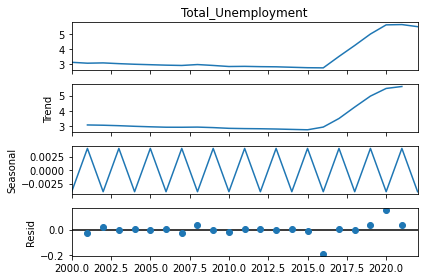

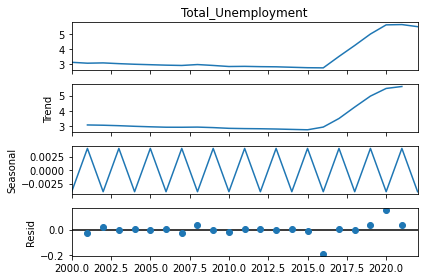

In [ ]:
##Seasonality (bonus)
series = pd.Series(unemployment_df['Total_Unemployment'])
results = seasonal_decompose(series, model='additive',period=2)
results.plot()

# Model Development 

In [ ]:
def unprediction_pipeline(unemployment_df, target_col):
    # Split the dataset into features and the target variable
    X = unemployment_df.drop(columns=[target_col])
    y = unemployment_df[target_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])


In [ ]:
pipeline.fit(X_train,y_train)

NameError: name 'X_train' is not defined